# 442 Project
Rei Meguro (rmeguro), Felix Lu (felixlu), Roshan Sadhu (therks)

## 1. Data Processing

In [ ]:
labels = {
    "Angelina Jolie": 0,
    "Brad Pitt": 1,
    "Denzel Washington": 2,
    "Hugh Jackman": 3,
    "Jennifer Lawrence": 4,
    "Johnny Depp": 5,
    "Kate Winslet": 6,
    "Leonardo DiCaprio": 7,
    "Megan Fox": 8,
    "Natalie Portman": 9,
    "Nicole Kidman": 10,
    "Robert Downey Jr": 11,
    "Sandra Bullock": 12,
    "Scarlett Johansson": 13,
    "Tom Cruise": 14,
    "Tom Hanks": 15,
    "Will Smith": 16,
}
label_classes = labels
n_classes = len(labels)
image_size = 224

import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        
        # Parse the folder structure
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                class_id = labels[folder]
                for file in os.listdir(folder_path):
                    if file.endswith('.jpg'):
                        file_path = os.path.join(folder_path, file)
                        self.data.append((file_path, class_id))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file_path, class_id = self.data[idx]
        image = Image.open(file_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_id

# dataset and image transformation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize( 
    #     mean=[0.5, 0.5, 0.5],
    #     std=[0.5, 0.5, 0.5]
    # )
])
dataset = CustomDataset(root_dir='./Celebrity Faces Dataset', transform=transform)

# splitting dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(len(dataset))

1800


## 2. Training a CNN on labeled faces

We train a CNN to classify between 17 Celebrity faces. The goal of this is so that we train a feature extractor that we can use to hopefully recognize new faces this model has never seen before.

In [3]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

In [ ]:
# define model (resnset)

class FacialModel(nn.Module):
    def __init__(self, num_classes, embedding_size = 512):
        super(FacialModel, self).__init__()
        if embedding_size != 512:
            raise ValueError("Sorry, only embedding size 512 is currently supported")
        
        self.base_model = models.resnet18() # weights=models.ResNet18_Weights
        self.base_model.fc = nn.Linear(embedding_size, num_classes)
        self.base_model.fc.register_forward_hook(self.get_embedding)
        
        self.embeddings = None

    def forward(self, x):
        return self.base_model(x)

    def get_embedding(self, model, input, output):
        self.embeddings = input[0].detach()

In [ ]:
# class FacialModel(nn.Module):
#     def __init__(self, num_classes, embedding_size):
#         super(FacialModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(128 * 28 * 28, embedding_size)
#         self.fc2 = nn.Linear(embedding_size, num_classes)
        
#         self.embedding = None

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1)
#         self.embedding = self.fc1(x)
#         x = self.fc2(F.relu(self.embedding))
#         return x

In [80]:
# loss function + optimizer
embedding_size = 512

loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FacialModel(num_classes=n_classes, embedding_size=embedding_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)

c:\Users\reime\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# training loop
def train_model(model, train_loader, optimizer, loss_fn, device, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for iters, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if iters % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}][{iters + 1}], Loss: {running_loss / (iters + 1):.4f}")
        
        # in case we don't end in an iteration multiple of 32
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
print(model)

FacialModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [19]:
# train model
train_model(model, train_loader, optimizer, loss_fn, device, epochs=3)

Epoch [1/3][1], Loss: 1.1457
Epoch [1/3][11], Loss: 0.8627
Epoch [1/3][21], Loss: 0.8536
Epoch [1/3][31], Loss: 0.8205
Epoch [1/3][41], Loss: 0.7931
Epoch [1/3][51], Loss: 0.7684
Epoch [1/3][61], Loss: 0.7464
Epoch [1/3][71], Loss: 0.7265
Epoch [1/3][81], Loss: 0.7274
Epoch [1/3], Loss: 0.7043
Epoch [2/3][1], Loss: 0.1541
Epoch [2/3][11], Loss: 0.1907
Epoch [2/3][21], Loss: 0.1909
Epoch [2/3][31], Loss: 0.1868
Epoch [2/3][41], Loss: 0.1678
Epoch [2/3][51], Loss: 0.1570
Epoch [2/3][61], Loss: 0.1435
Epoch [2/3][71], Loss: 0.1356
Epoch [2/3][81], Loss: 0.1308
Epoch [2/3], Loss: 0.1240
Epoch [3/3][1], Loss: 0.0364
Epoch [3/3][11], Loss: 0.0405
Epoch [3/3][21], Loss: 0.0378
Epoch [3/3][31], Loss: 0.0348
Epoch [3/3][41], Loss: 0.0332
Epoch [3/3][51], Loss: 0.0342
Epoch [3/3][61], Loss: 0.0343
Epoch [3/3][71], Loss: 0.0324
Epoch [3/3][81], Loss: 0.0312
Epoch [3/3], Loss: 0.0302


In [ ]:
def save_model(model, optimizer, epoch, path="trained_model.pth"):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at '{path}'")

def load_model(model, optimizer, path="trained_model.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    print(f"Checkpoint loaded from '{path}' (Epoch: {epoch})")
    return epoch

save_model(model, optimizer, 3)

In [ ]:
# evaluate the model
load_model(model, optimizer)

def test_model(model, test_loader, device):
    model.eval()
    totals = 0
    corrects = 0
    incorrects = []
    incorrects_labels = []
    
    with torch.no_grad():
        for iters, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.argmax(outputs, 1)

            totals += labels.size(0)
            corrects += (predicted == labels).sum().item()
            incorrects.extend(images[predicted != labels])
            incorrects_labels.extend(predicted[predicted != labels])
        accuracy = 100 * corrects / totals
        print(f"Test accuracy: {accuracy:.2f}%")
    
    return incorrects, incorrects_labels

incorrects, incorrects_labels = test_model(model, test_loader, device)

C:\Users\reime\AppData\Local\Temp\ipykernel_19884\1367033254.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Checkpoint loaded from 'trained_model.pth' (Epoch: 3)
Test accuracy: 87.50%


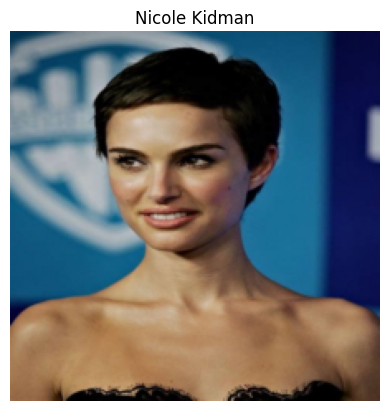

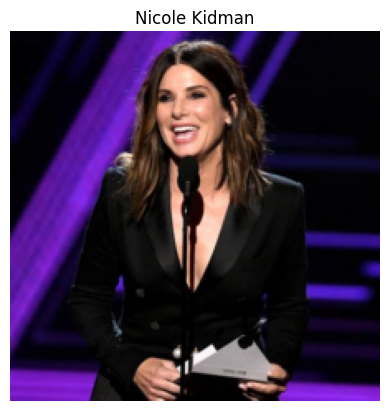

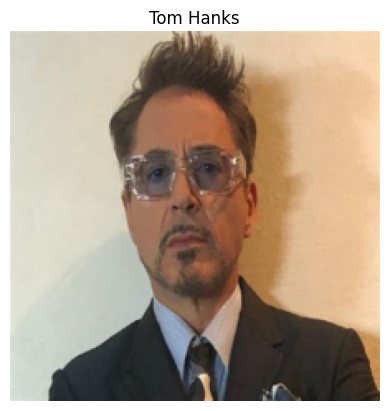

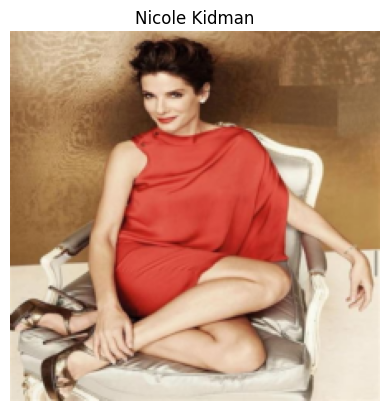

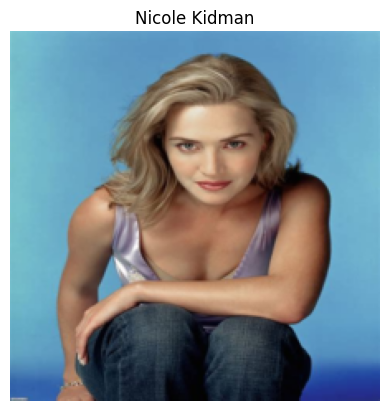

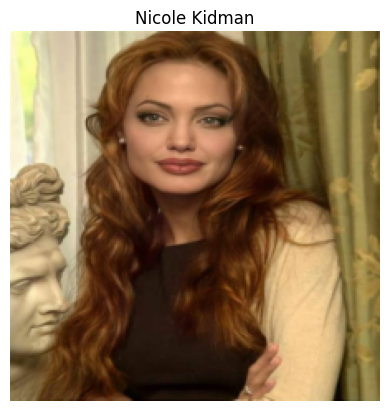

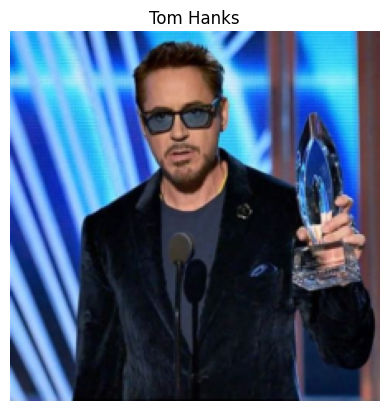

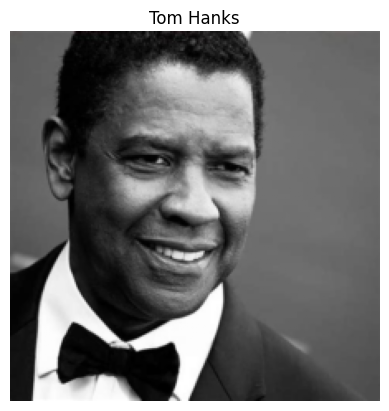

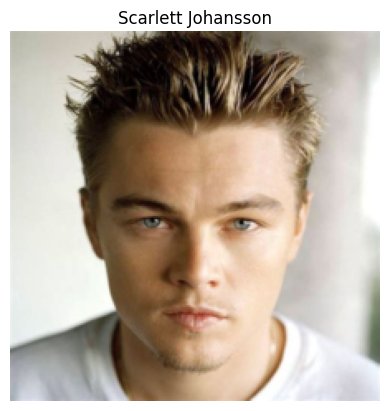

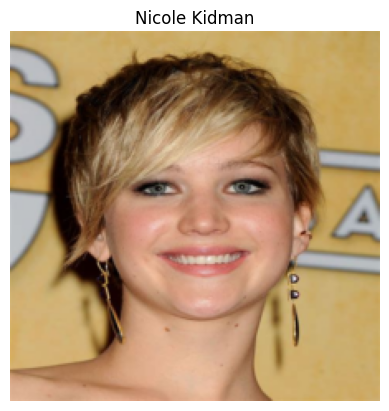

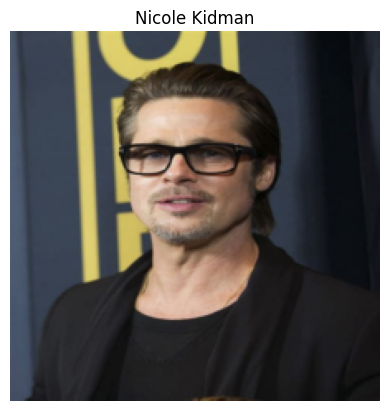

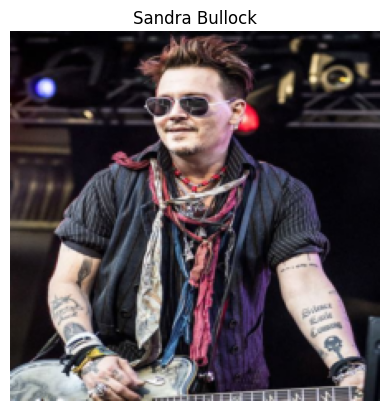

In [69]:
# show samples we got wrong
import matplotlib.pylab as plt
class_labels = {v: k for k, v in labels.items()}

for i in range(0, len(incorrects), 4):
    plt.imshow(incorrects[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(class_labels[incorrects_labels[i].item()])
    plt.show()

## 3. Creating a generalized facial recognition model

We now use the trained model but cut off its last layer (the one which selects between 17 classes) to use it as a general embedding model for any faces. To classify a face, we first register it to the model by embedding a few samples and saving it in the vector database.

To classify a face, we embed the face and look for its nearest neighbors in the database. We then weigh each class based on the distances of a neighbor from that class, and output the name with the highest weight. If the closest vector is too far, we simply output None as it likely isn't anyone in the dataset. 

In [117]:
# creating the generalized classifier

import chromadb
import uuid

class GeneralFaceRec:
    def __init__(self, model, db_name: str = "facerec"):
        self.db_name = db_name
        self.client = chromadb.PersistentClient(path="./database")
        self.collection = self.client.get_or_create_collection(
            db_name, metadata={"hnsw:space": "cosine"}
        )
        self.model = model
        
        # parameters
        self.threshold = 0.8  # how similar does it have to be to count as a match
        self.k = 5  # how many neighbors to consider
        self.eps = 0.0001  # small number to avoid dividing by 0
    
    def set_params(self, threshold: float = None, k: int = None, eps: float = None):
        assert(k is None or k >= 1)
        assert(eps is None or eps > 0)
        
        threshold = threshold or self.threshold
        k = k or self.k
        eps = eps or self.eps
    
    def reset_database(self):
        self.client.delete_collection(name=self.db_name)
        self.collection = self.client.get_or_create_collection(
            self.db_name, metadata={"hnsw:space": "cosine"}
        )
    
    
    
    def embed(self, images):
        self.model(images)
        return self.model.embeddings.tolist()
    
    def register_face(self, images, name: str):
        embeddings = self.embed(images)
        
        self.collection.upsert(
            ids = [str(uuid.uuid4()) for _ in images],
            embeddings=embeddings,
            metadatas=[{"name": name} for _ in images]
        )
    
    def identify_faces(self, images) -> list[str | None]:
        embedding = self.embed(images)
        
        result = self.collection.query(
            query_embeddings=embedding,
            n_results=self.k,
            include=["metadatas", "distances"]
        )
       
        all_distances = result["distances"]
        all_metadatas = result["metadatas"]
        n_inputs = images.size(0)
        
        results = []
        for i in range(n_inputs):
            distances = all_distances[i]
            metadatas = all_metadatas[i]
            
            closest_distance = distances[0]
            if closest_distance > self.threshold:
                results.append(None)
                continue
            
            scores = {}
            for metadata, distance in zip(metadatas, distances):
                name = metadata["name"]
                scores.setdefault(name, 0)
                scores[name] += 1.0 / (self.eps + distance)  # smaller the distance, higher the score
            
            results.append(max(scores, key=scores.get))
        return results

In [106]:
# register celebrities
facerec = GeneralFaceRec(model)
facerec.set_params(k = 3)
facerec.reset_database()

register_count = 5  # how many images of each person to register
to_register = [[] for _ in range(n_classes)]

for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    name = class_labels[label]
    
    if (len(to_register[label]) < register_count):
        to_register[label].append(img)

for label in range(n_classes):
    assert(len(to_register[label]) == register_count)
    facerec.register_face(torch.stack(to_register[label]), class_labels[label])

In [121]:
# evaluate on test set
facerec = GeneralFaceRec(model)
facerec.set_params(k = 3)

totals = 0
corrects = 0
incorrects = []
incorrects_labels = []

for iters, (images, labels) in enumerate(test_loader):
    results = facerec.identify_faces(images)
    predicted = torch.tensor([label_classes.get(name, -1) for name in results])
    
    totals += labels.size(0)
    corrects += (labels == predicted).sum().item()
    incorrects.extend(images[predicted != labels])
    incorrects_labels.extend(predicted[predicted != labels])

accuracy = 100 * corrects / totals
print(f"Test accuracy: {accuracy:.2f}%")
    
    
# i = 350
# print(class_labels[train_dataset[i][1]])
# facerec.identify_faces(torch.stack([train_dataset[i][0]]))

Test accuracy: 93.06%


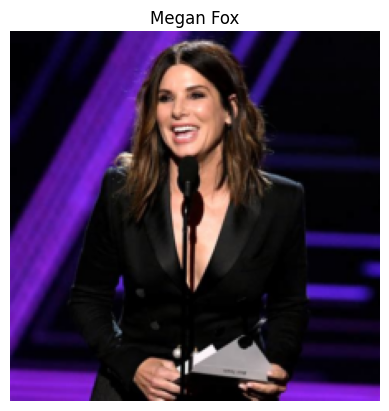

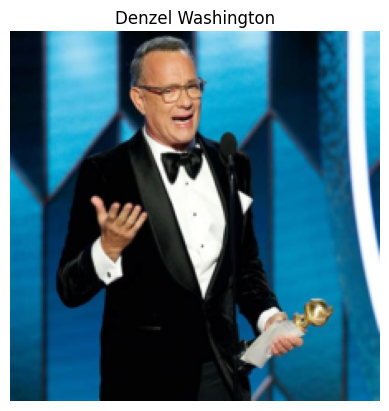

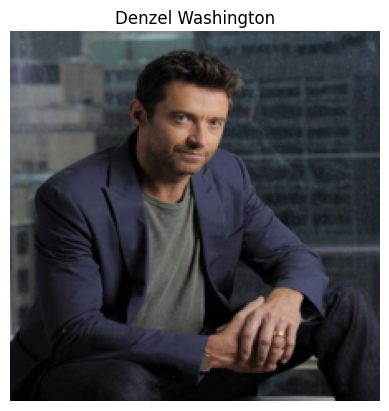

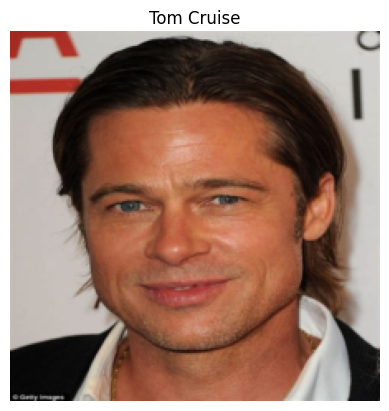

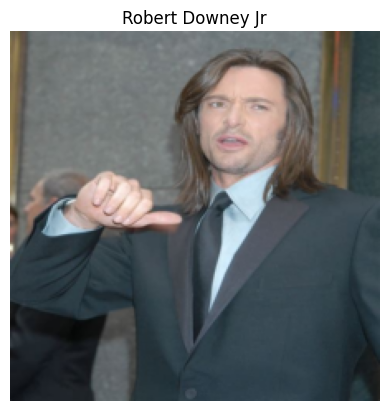

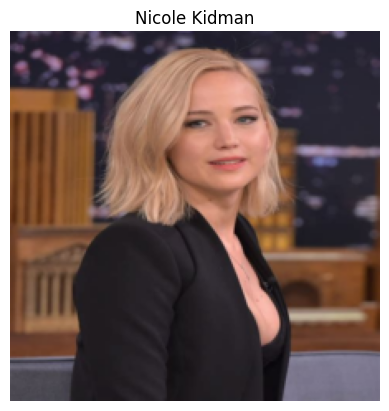

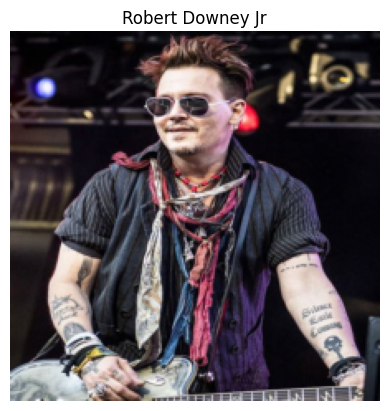

In [124]:
# show samples we got wrong
for i in range(0, len(incorrects), 4):
    plt.imshow(incorrects[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(class_labels[incorrects_labels[i].item()])
    plt.show()